# ML in Bioinf, Assignment Week 7, Team C

In [2]:
%pylab inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline
from collections import Counter
from xml.etree import ElementTree as ET

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data matrix file and the annotated labels MINiML file

In [4]:
root = ET.parse("GSE68086_family.xml").getroot()
ns = {"MINiML": "http://www.ncbi.nlm.nih.gov/geo/info/MINiML"}

In [5]:
name_dict = {}
for sample in root.findall('MINiML:Sample', ns):
    for channel in sample.findall('MINiML:Channel', ns):
        name = channel.findall('MINiML:Source', ns)[0].text
        if "HD" in name or "Control" in name:
            name_dict[name] = "HD"
        else:
            for characteristic in channel.findall('MINiML:Characteristics', ns):
                if characteristic.attrib["tag"] == "cancer type":
                    name_dict[name] = characteristic.text.strip()
print("Example: ", name, " Type: ", name_dict[name])

Example:  MGH-NSCLC-L65-TR523  Type:  Lung


In [6]:
# Pull in training data
training_data = pd.read_csv('GSE68086_TEP_data_matrix.txt', sep='\t',index_col=0).T
training_data.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000273481,ENSG00000273483,ENSG00000273484,ENSG00000273485,ENSG00000273486,ENSG00000273487,ENSG00000273488,ENSG00000273489,ENSG00000273492,ENSG00000273493
3-Breast-Her2-ampl,0,0,44,26,81,171,34,83,0,14,...,0,0,0,0,1,0,0,1,4,0
8-Breast-WT,0,0,14,1,98,99,0,107,0,5,...,0,0,0,0,0,0,0,0,0,0
10-Breast-Her2-ampl,0,0,16,14,18,25,0,62,4,13,...,0,0,0,0,0,0,0,0,0,0
Breast-100,0,0,8,0,17,4,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
15-Breast-Her2-ampl,17,0,9,4,0,49,0,40,0,10,...,0,0,0,0,0,0,0,0,0,0


## Preprocess the cancer labels, adjust for label imbalance and split train/test

In [7]:
# Extract cancer labels
# training_data["cancer"] = list(training_data.index)
# training_data["cancer"] = training_data.cancer.str.extract(r'(Breast|BrCa|CRC|GBM|NSCLC|Lung|Chol|Liver|HBC|Panc|Unknown|HD|Control)')
# training_data.loc[training_data.cancer =="Breast","cancer"] = "BrCa"
# training_data.loc[training_data.cancer=="Lung","cancer"] = "NSCLC"
# training_data.loc[training_data.cancer=="Chol","cancer"] = "HBC"
# training_data.loc[training_data.cancer=="Liver","cancer"] = "HBC"
# training_data.loc[training_data.cancer=="Panc","cancer"] = "PAAD"
# training_data.loc[training_data.cancer=="Control","cancer"] = "HD"
training_data["cancer"] = [name_dict[x] for x in list(training_data.index)]
training_data.cancer.unique()

array(['Breast', 'Hepatobiliary', 'CRC', 'GBM', 'HD', 'HC', 'Lung',
       'Pancreas'], dtype=object)

In [8]:
training_data['cancer'].value_counts()

Lung             60
HD               54
CRC              42
GBM              40
Breast           39
Pancreas         35
Hepatobiliary    14
HC                1
Name: cancer, dtype: int64

In [9]:
training_data.shape

(285, 57737)

In [10]:
# Fix random seed for reproducibility
seed = 3
# np.random.seed(seed)

In [11]:
# Exclude Unknown cases
# Get labels for training data
Y = training_data.cancer != "HD"

# Get training data as numpy array
X = training_data.drop(['cancer'], axis=1).astype(float).values

In [12]:
rus = RandomUnderSampler(1,random_state=seed)
ros = RandomOverSampler(1,random_state=seed)

In [13]:
# Set parameters for the Random Forest Model
rfc = RandomForestClassifier(random_state=seed, n_estimators=100)

In [14]:
# Set parameters for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [15]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [16]:
# Determine shape of training data features for cross-validation
X_train.shape

(199, 57736)

In [17]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(199,)

In [18]:
# oversample
X_over, Y_over = ros.fit_resample(X_train, Y_train)

# summarize class distribution
print(Counter(Y_over))

Counter({True: 165, False: 165})


In [31]:
# Determine shape of oversampled training data features for cross-validation
X_over.shape

(330, 57736)

In [32]:
# Determine shape of oversampled training data features for cross-validation
Y_over.shape

(330,)

## Get the training accuracy and AUC using kfold cross-validation

In [33]:
#Print accuracy
probabilities = cross_val_predict(rfc, X_over, Y_over, cv=kfold, method='predict_proba')


In [34]:
def predict_classes(probabilities):
    """Predict class labels from probabilities"""
    
    predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)

In [35]:
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_over, predict_classes(probabilities)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_over, predict_classes(probabilities)))

Cross validation accuracy:
0.9696969696969697

Cross validation classification report

              precision    recall  f1-score   support

       False       0.94      1.00      0.97       165
        True       1.00      0.94      0.97       165

    accuracy                           0.97       330
   macro avg       0.97      0.97      0.97       330
weighted avg       0.97      0.97      0.97       330



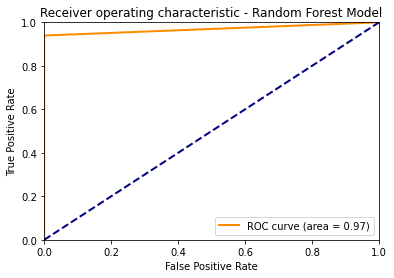

In [36]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_over, predict_classes(probabilities))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

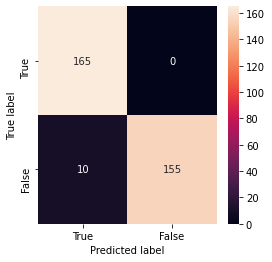

In [60]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_over, predict_classes(probabilities))
class_names = Y_over.unique()
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Show the 18 most important features

In [53]:
# Rebuild RFC model
rfc_fit = rfc.fit(X_over, Y_over)

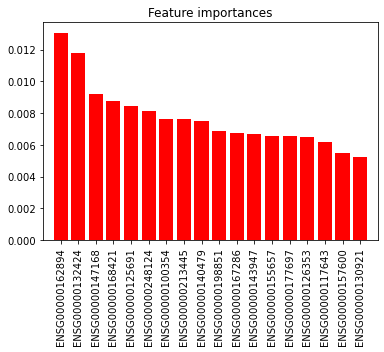

The 18 most important features are: 

Index(['ENSG00000162894', 'ENSG00000132424', 'ENSG00000147168',
       'ENSG00000168421', 'ENSG00000125691', 'ENSG00000248124',
       'ENSG00000100354', 'ENSG00000213445', 'ENSG00000140479',
       'ENSG00000198851', 'ENSG00000167286', 'ENSG00000143947',
       'ENSG00000155657', 'ENSG00000177697', 'ENSG00000126353',
       'ENSG00000117643', 'ENSG00000157600', 'ENSG00000130921'],
      dtype='object')


In [54]:
# Create function to determine the feature importance 
importances = rfc_fit.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(18),importances[indices][:18],color="r", align="center")
plt.xticks(range(18),training_data.T.index[indices][:18],rotation = 90)
plt.xlim([-1, 18])
plt.show()
print('The 18 most important features are: \n')
print(training_data.T.index[indices][:18])

## Get the test data accuracy and AUC

In [55]:
# Determine performance on test set
test_prob = rfc_fit.predict_proba(X_test)

In [56]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_test, predict_classes(test_prob)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_test, predict_classes(test_prob)))


Cross validation accuracy:
0.9069767441860465

Cross validation classification report

              precision    recall  f1-score   support

       False       0.88      0.70      0.78        20
        True       0.91      0.97      0.94        66

    accuracy                           0.91        86
   macro avg       0.89      0.83      0.86        86
weighted avg       0.91      0.91      0.90        86



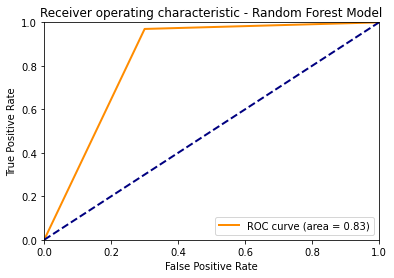

In [57]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predict_classes(test_prob))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

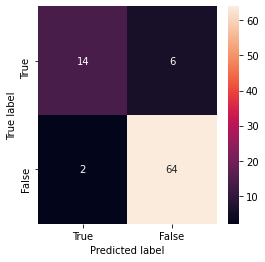

In [59]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, predict_classes(test_prob))
class_names = Y_over.unique()
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Get testing accuracy again using feature selection of "r" features

In [230]:
# takes a while
maxtrain = 0
maxtest = 0
maxr = 0
for r in range(15, 180):
    X_over_select = np.take(X_over, indices[:r], 1)
    rfc_fit_select = rfc.fit(X_over_select, Y_over)
    probabilities_select = cross_val_predict(rfc, X_over_select, Y_over, cv=kfold, method='predict_proba')
    acctrain = metrics.accuracy_score(Y_over, predict_classes(probabilities_select))
    X_test_select = np.take(X_test, indices[:r], 1)
    test_prob_select = rfc_fit_select.predict_proba(X_test_select)
    acctest =  metrics.accuracy_score(Y_test, predict_classes(test_prob_select))
    if acctrain > maxtrain:
        if acctest > maxtest:
            maxtrain = acctrain 
            maxtest = acctest
            maxr = r
print(maxr)

162


In [221]:
r = 162

In [222]:
# Rebuild RFC model
X_over_select = np.take(X_over, indices[:r], 1)
rfc_fit_select = rfc.fit(X_over_select, Y_over)

In [223]:
#Print accuracy
probabilities_select = cross_val_predict(rfc, X_over_select, Y_over, cv=kfold, method='predict_proba')
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_over, predict_classes(probabilities_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_over, predict_classes(probabilities_select)))

Cross validation accuracy:
0.9757575757575757

Cross validation classification report

              precision    recall  f1-score   support

       False       0.95      1.00      0.98       165
        True       1.00      0.95      0.98       165

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



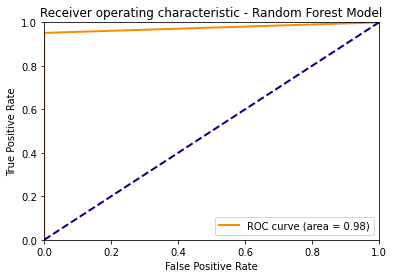

In [224]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_over, predict_classes(probabilities_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

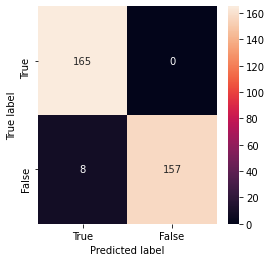

In [225]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_over, predict_classes(probabilities_select))
class_names = Y_over.unique()
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [226]:
# Determine performance on test set
X_test_select = np.take(X_test, indices[:r], 1)
test_prob_select = rfc_fit_select.predict_proba(X_test_select)

In [227]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Y_test, predict_classes(test_prob_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Y_test, predict_classes(test_prob_select)))


Cross validation accuracy:
0.9186046511627907

Cross validation classification report

              precision    recall  f1-score   support

       False       0.93      0.70      0.80        20
        True       0.92      0.98      0.95        66

    accuracy                           0.92        86
   macro avg       0.92      0.84      0.87        86
weighted avg       0.92      0.92      0.91        86



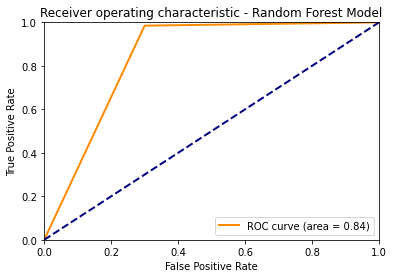

In [228]:
# Plot ROC for Random Forest
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predict_classes(test_prob_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

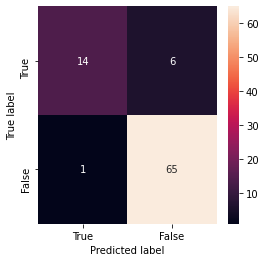

In [229]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, predict_classes(test_prob_select))
class_names = Y_over.unique()
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()